# EDA: Sentiment Analysis

By now, I've amassed a corpus of articles from three sources: *The New York Times* (1,425 articles), *The Washington Post* (447 articles), and FoxNews.com (309 articles). I'm aiming to have at least 1,000 articles from each source, but I'll start examining trends in the data I currently have.

Sentiment analysis is a natural language processing technique that seeks to identify the polarity of written text - whether the document expresses positive, negative, or neutral feelings. This technique is commonly applied to text that may express strong opinions, such as reviews or social media posts, but I'm going to apply it to news articles and see if there are any differences in the sentiments expressed by different publications or in different sections.

The goal for this analysis is to derive scores for each article's body and title based on the positivity or negativity of the words they contain, and see if these score might be useful features in predicting what section the article is from. Sentiment scores range from 1 (very positive) to -1 (very negative), and I'm expecting a relatively small range for articles in this corpus, since news is presumably objective. [SentiWordNet](http://sentiwordnet.isti.cnr.it/) is a resource that maps tens of thousands of English words to a sentiment score. Since language is complex, and the meaning of a given word can vary significantly depending on the context in which it's used, these scores are imperfect, but they'll provide a general picture of the sentiment behind each article.

## ArticleData Class

I've been scraping each of my three sources at least twice a day to get fresh news and storing articles in a local postgres database. To facilitate the process of retrieving data and automate some of the cleaning and formatting, I've created a service class ArticleData. Objects of this class have a call method that creates a dataframe of article titles, dates, bodies, sections, and sources. Any articles that have a body of under 200 characters in length are dropped, all dates converted to datetime format, and the various sections from each source are condensed into business, world, politics, science/health, technology, sports, education, entertainment, or opinion. 

## Sentiment Scores

Since I'll be looking at sentiment scores, ArticleData objects also calculate scores for article bodies and titles, and store them in columns in the dataframes they return when called. I've borrowed the compute_score function from [this Github gist](https://gist.github.com/rtkgupta/da5a7c5b66383d8db2b1) and written it into the call method. This function works by using NLTK's WordNetLemmatizer to lemmatize each word in a text, and the PerceptronTagger to tag the part of speech of each word in the text as a noun, verb, adjective, or adverb. This helps SentiwordNet to assign the word to a synset, or synonym set, for which it can assign a positive or negative value. Since a word can belong to multiple synsets, the function selects the most common one.

In [1]:
from articledata import *

/Users/teresaborcuch/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/teresaborcuch/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
data = ArticleData().call()

In [322]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

In [9]:
data = pd.read_pickle('/Users/teresaborcuch/capstone_project/notebooks/pickled_data.pkl')

In [10]:
data.shape

(2322, 9)

In [11]:
data.head(1)

,title,date,body,section,source,condensed_section,SA_body,SA_title,SA_diff
0,$5 Million for a Super Bowl Ad. Another Millio...,2017-01-29,"This month, Anheuser-Busch InBev hosted a doze...",business,NYT,business,0.01624,-0.023148,0.039388


## Trends in Sentiment Scores

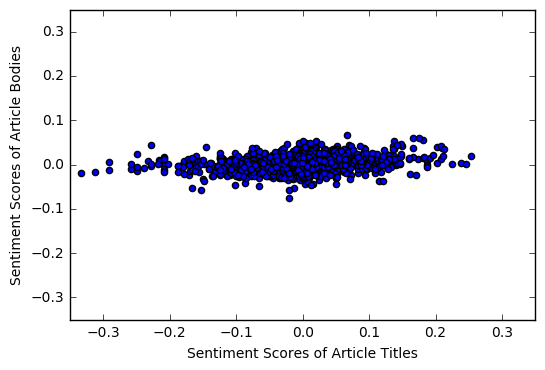

In [14]:
plt.scatter(data['SA_title'], data['SA_body'])
plt.xlabel('Sentiment Scores of Article Titles')
plt.ylabel('Sentiment Scores of Article Bodies')
plt.xlim(-0.35, 0.35)
plt.ylim(-0.35, 0.35)
plt.show()

This plot shows the relationship between title scores and body scores for all articles. Interestingly, there seems to be little relationship between the sentiment score of the title and that of the body. The other feature of note is that article titles have a much wider score range than the bodies. This may be because the compute_score function averages the score of each word over the entire length of the document. Since article bodies contain many more words, and therefore more neutral words, their scores will be lower.

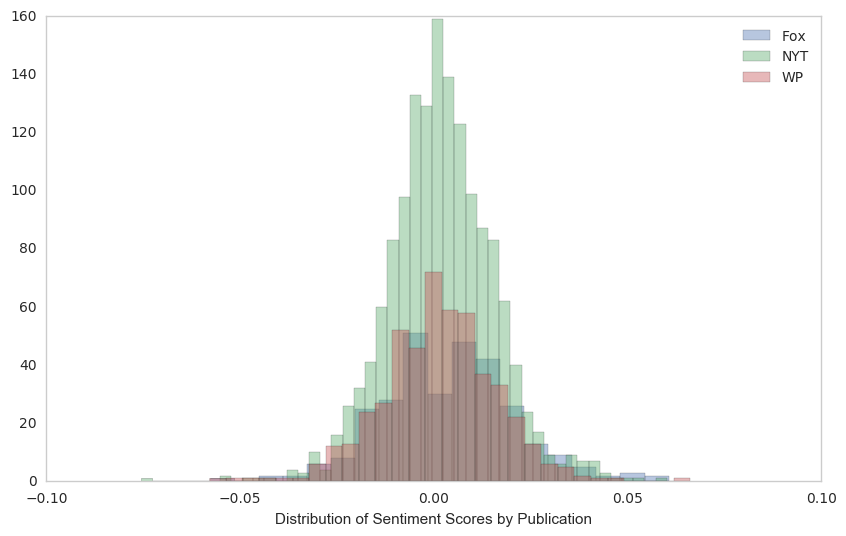

In [16]:
mask1 = (data['source'] == 'Fox')
mask2 = (data['source'] == 'WP')
mask3 = (data['source'] == 'NYT')

score_dict = {'Fox': data[mask1]['SA_body'],
           'WP': data[mask2]['SA_body'],
           'NYT' : data[mask3]['SA_body']}

sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(figsize = (10,6))
for x in score_dict.keys():
    ax = sns.distplot(score_dict[x], kde = False, label = x)
    ax.set_xlabel("Distribution of Sentiment Scores by Publication")
ax.legend()
ax.set_xlim(-0.1, 0.1)
plt.show()

This histogram shows the distribution of article bodies' sentiment scores for all three publications. As I suspected, they are normally distributed tightly around zero.

In [8]:
pd.DataFrame(data.pivot_table(
        values = ['SA_title', 'SA_body'], 
        index = 'condensed_section', 
        aggfunc =np.mean)).sort_values('SA_body', ascending = False)

,SA_body,SA_title
condensed_section,,
entertainment,0.009675,0.005642
education,0.007797,0.005974
technology,0.005968,0.001077
sci_health,0.005271,0.000586
business,0.004649,0.005713
sports,0.001776,-0.004155
other,0.000342,0.003976
opinion,0.000138,-0.011153
politics,-0.000470,-0.002535


Let's see which sections are the most positive and negative. This table contains the average sentiment scores of bodies and titles for each section, sorted by highest-scoring body to lowest. The averages are clustered around zero, but entertainment and education have the most positive content in their article bodies, and articles from the world news setion have the most negative.

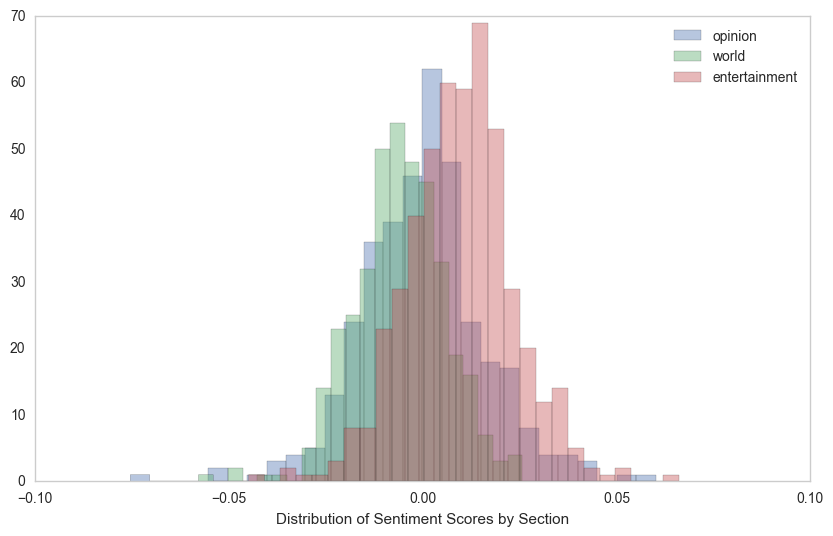

In [9]:
mask1 = (data['condensed_section'] == 'opinion')
mask2 = (data['condensed_section'] == 'entertainment')
mask3 = (data['condensed_section'] == 'world')

score_dict = {'opinion': data[mask1]['SA_body'],
           'entertainment': data[mask2]['SA_body'],
           'world' : data[mask3]['SA_body']}

sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(figsize = (10,6))
for x in score_dict.keys():
    ax = sns.distplot(score_dict[x], kde = False, label = x)
    ax.set_xlabel("Distribution of Sentiment Scores by Section")
ax.legend()
ax.set_xlim(-0.1, 0.1)
plt.show()

This histogram shows the distribution of scores for the article bodies from three sections: opinion, world, and entertainment. The entertainment section has more articles scoring above zero than the other two sections, and the world news section has fewer. This makes sense, since the entertainment section is composed of stores about "lighter" topics such as the arts, dining, or travel, and the world news section might be a bit "heavier". It also seems like the opinion section has a wider range of scores than the other two.

## Evaluating Sentiment For Particular Topics

It might be interesting to investigate whether certain publications differ in the sentiment of their reporting on particular topics, or whether the sentiment for a particular topic varies among sections of the same publication. I've written a function that aggregates the sentiment scores for articles from a particular publication or section into a dictionary with two keys: topic and non-topic. These dictionaries are readily plottable, and I can compare among sections and sources.

In [10]:
# create dictionaries for each publication
nyt_trump = evaluate_topic(data = data, section = 'opinion', source = 'NYT', topic = 'Trump')
fox_trump = evaluate_topic(data = data, section = 'opinion', source = 'Fox', topic = 'Trump')
wp_trump = evaluate_topic(data = data, section = 'opinion', source = 'WP', topic = 'Trump')

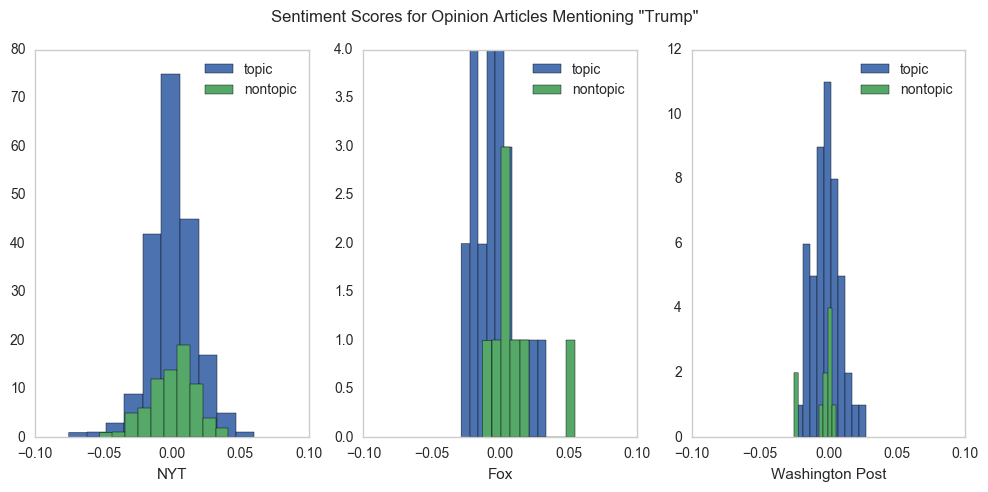

In [11]:
# plot dictionaries
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize = (12, 5))
count = 1
label_dict = {1: "NYT", 2: "Fox", 3: "Washington Post"}

for score_dict in [nyt_trump, fox_trump, wp_trump]:
    ax = fig.add_subplot(1, 3, count)
    for key in score_dict.keys():
        ax.hist(score_dict[key], label = key)
        ax.set_xlabel(label_dict[count])
    ax.legend()
    ax.set_xlim(-0.1, 0.1)
    
    count +=1
    
plt.suptitle('Sentiment Scores for Opinion Articles Mentioning "Trump"')
plt.show()

The obvious observation from these graphs is that more opinion pieces mention Trump than not for all three publications, and the sentiment of the Trump-related articles spans a wider range than non-Trump-related articles.

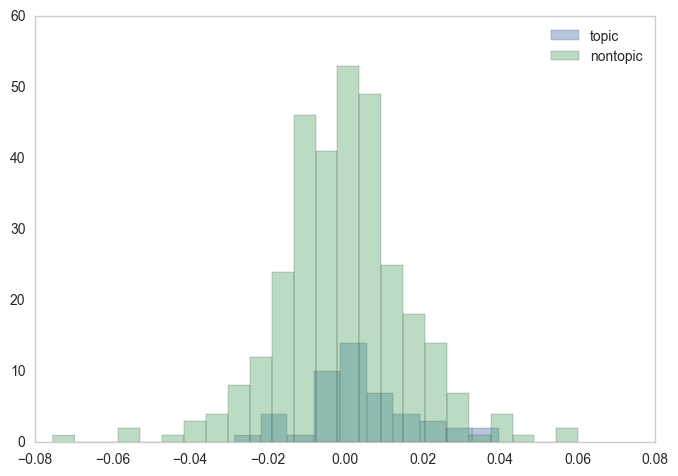

Mean Score for Opinion Pieces Mentioning "education":  0.00412250407705
Mean Score for Opinion Pieces Not Mentioning "education":  -0.000467516117571


In [12]:
# Compare sentiment scores for opinion vs non-opinion pieces that mention education
ed_dict = evaluate_topic(data = data, section = 'opinion', topic = 'education')

for key in ed_dict.keys():
    sns.distplot(ed_dict[key], kde = False, label = key)
plt.legend()
plt.show()

print 'Mean Score for Opinion Pieces Mentioning "education": ', np.mean(ed_dict['topic'])
print 'Mean Score for Opinion Pieces Not Mentioning "education": ', np.mean(ed_dict['nontopic'])

Here, I'm comparing opinion pieces from all three publications that mention education to those that don't. Opinion articles about education have a higher rating on average than those that don't, across all publications.

## Evaluating Fluctuations in Sentiment Over Time

In [13]:
data.head(1)

,title,date,body,section,source,condensed_section,SA_body,SA_title,SA_diff
0,$5 Million for a Super Bowl Ad. Another Millio...,2017-01-29,"This month, Anheuser-Busch InBev hosted a doze...",business,NYT,business,0.01624,-0.023148,0.039388


In [476]:
class EvaluateTime():
    
    def __init__(self, data = None, section = None, source = None, topic = None, date = None):
        self.data = data
        self.section = section
        self.source = source
        self.topic = topic
        self.date = date
        
    def call(self):
        #self.plot_date_dict, 
        self.range_date_dict = self.make_dict()
        return self
        
    def make_dict(self):
        # define masks
        section_mask = (self.data['condensed_section'] == self.section)
        source_mask = (self.data['source'] == self.source)
        date_mask = (self.data['date'] > self.date)
    
        # initialize lists for plot_date_dict
        topic_scores = []
        dates = []
        
        # initialize other dict
        range_date_dict = {}
    
        if not self.date:
            print "Please select a start date."
        
        # make plot_date_dict from appropriate subset of data
        else:
            if self.section and self.source:
                masked_data = self.data[section_mask & source_mask & date_mask]
                
            elif self.section and (not self.source):
                masked_data = self.data[section_mask & date_mask]
                
            elif self.source and (not self.section):
                masked_data = self.data[source_mask & date_mask]
                
            else:
                masked_data = self.data[date_mask]
                  
            for i, row in masked_data.iterrows():
                
                if self.topic in row[2]:
                    topic_scores.append(row[6])
                    dates.append(row[1])
                    
                    # add to range_date_dict where keys are the dates and the vales are a list of scores
                    if row[1] not in range_date_dict.keys():
                        range_date_dict[row[1]] = [row[6]]

                    elif row[1] in range_date_dict.keys():
                        (range_date_dict[row[1]]).append(row[6])

        #plot_date_dict = {'date': dates, 'score': topic_scores}
        return range_date_dict #plot_date_dict, 

    def plot_time(self):
        
        x = self.range_date_dict.keys()
        x.sort()
        ordered_x = []
        y = []
        for val in x:
            ordered_x.append(val)
            values = self.range_date_dict[val]
            mean = np.mean(values)
            y.append(mean)

        # define upper and lower boundaries for error bars
        upper_bounds = [max(self.range_date_dict[x]) for x in ordered_x]
        lower_bounds = [min(self.range_date_dict[x]) for x in ordered_x]
        
        # define distance for upper error bar
        y_upper = zip(y, upper_bounds)
        upper_error = [abs(pair[0] - pair[1]) for pair in y_upper]
  
        # define distance for lower error bar 
        y_lower = zip(y, lower_bounds)
        lower_error = [abs(pair[0] - pair[1]) for pair in y_lower]
    
        asymmetric_error = [lower_error, upper_error]
        
        plt.plot(ordered_x, y, c = 'r', marker = 'o')
        plt.errorbar(ordered_x, y, yerr = asymmetric_error, ecolor = 'r', capthick = 1)
        plt.xlim(min(ordered_x) + timedelta(days = -1), max(ordered_x) + timedelta(days = 1))
        plt.xticks(rotation = 70)
        plt.show()

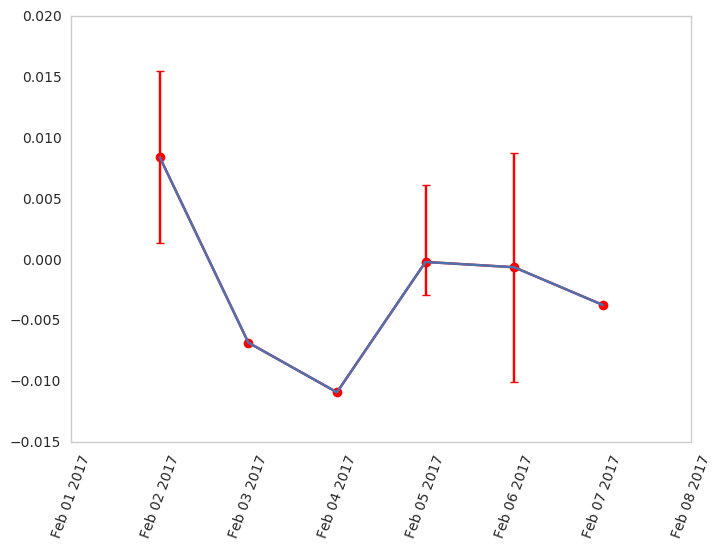

In [477]:
et = EvaluateTime(data = data, source = 'Fox', section = 'politics', topic = 'Trump', date = datetime(2017, 1, 24)).call()
et.plot_time()

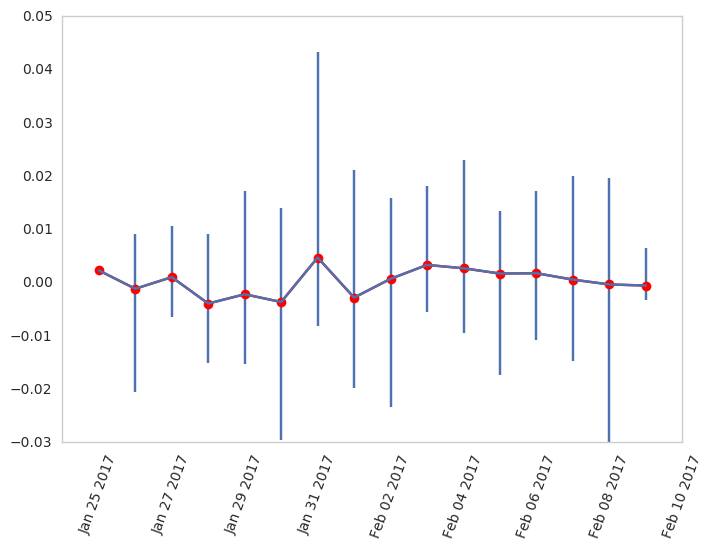

In [464]:
et = EvaluateTime(data = data, source = 'NYT', section = 'politics', topic = 'Trump', date = datetime(2017, 1, 24)).call()
et.plot_time()

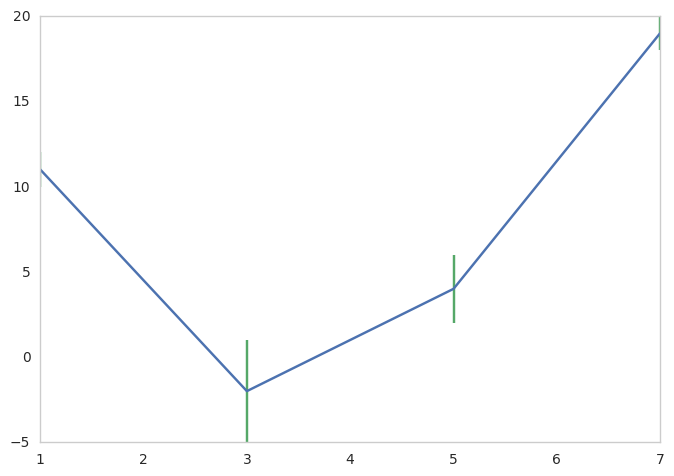

In [97]:
# make it so plot_time returns the graph as an object so that it can be manipulatedimport matplotlib.pyplot as plt
a = [1,3,5,7]
b = [11,-2,4,19]
plt.plot(a,b)

c = [1,3,2,1]
plt.errorbar(a,b,yerr=c, linestyle="None")

plt.show()